# Spatial mapping to tranfer cell type labels and expression values

In this tutorial, we will demonstrate how CellMapper can be used to transfer labels and expression values from a dissociated reference to a spatial query dataset. To map along the observation (`obs`) dimension, we will use the `ObsMapper` class. 

Along the way, we'll use [squidpy](https://squidpy.readthedocs.io/en/stable/index.html) {cite:p}`palla2022squidpy` for plotting and [Harmony](https://github.com/lilab-bcb/harmony-pytorch) {cite:p}`korsunsky2019fast` to compute a joint latent representation between spatial and dissociated data. 

## Preliminaries

### Import packages & data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import warnings
import scanpy as sc
import squidpy as sq
import anndata as ad
from harmony import harmonize
from cellmapper import ObsMapper
import seaborn as sns
import numpy as np

/Users/mlange/miniforge3/envs/cellmapper/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/mlange/miniforge3/envs/cellmapper/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [3]:
sc.settings.set_figure_params(scanpy=True, frameon=False, fontsize=14)

Load the seqFISH data of {cite:p}`lohoff2022integration` as a spatial query dataset and the scRNA-seq data of {cite:p}`pijuan2019single` as a dissociated reference dataset. Both profile mouse embryogenesis at approximately embryonic day (E) 8.5. 

In [4]:
ad_sp = sc.read("data/spatial_data.h5ad", backup_url="https://figshare.com/ndownloader/files/54145250")
ad_sp

AnnData object with n_obs × n_vars = 51787 × 351
    obs: 'embryo', 'pos', 'z', 'embryo_pos', 'embryo_pos_z', 'Area', 'celltype_seqfish', 'sample_seqfish', 'umap_density_sample', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    uns: 'celltype_harmonized_colors', 'celltype_seqfish_colors', 'embryo_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_orig', 'spatial'
    varm: 'PCs'

In [5]:
ad_diss = sc.read("data/dissociated_data.h5ad", backup_url="https://figshare.com/ndownloader/files/54145217")
ad_diss

AnnData object with n_obs × n_vars = 16496 × 18499
    obs: 'barcode', 'sample_rna', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype_rna', 'haem_subclust', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutDPT', 'endo_gutCluster', 'sizefactor', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_harmonized_colors', 'celltype_rna_colors', 'cluster_colors', 'hvg', 'pca', 'sample_colors', 'sequencing.batch_colors', 'stage_colors', 'theiler_colors', 'umap'
    obsm: 'X_endo_gephi', 'X_endo_gut', 'X_haem_gephi', 'X_pca', 'X_umap', 'X_umap_orig'
    varm: 'PCs'

The spatial data contains all genes measured with seqFISH, the dissociated data contains all genes that passed basic filtering criteria. In both objects, `.X` corresponds raw counts. We manually harmonized cell type annotations (stored in `.obs["celltype_harmonized"]` in either object), following ENVI {cite:p}`haviv2025covariance`. 

### Basic preprocessing

Later on, we will want to evaluate the sucess of expression imputation. For that, let's annotate genes as either `test` or `train`. 

In [6]:
n_test_genes = 50
rng = np.random.default_rng(seed=0)

# annotate test genes
shared_genes = set(ad_diss.var_names).intersection(set(ad_sp.var_names))
test_genes = rng.choice(list(shared_genes), replace=False, size=n_test_genes)
train_genes = list(shared_genes - set(test_genes))

# format as .var columns
for adata in [ad_sp, ad_diss]:
    for key, genes in zip(["is_train", "is_test"], [train_genes, test_genes], strict=False):
        adata.var[key] = False
        adata.var.loc[genes, key] = True

print(f"Using {len(test_genes)} genes for testing and {len(shared_genes) - len(test_genes)} for training.")

Using 50 genes for testing and 300 for training.


Let's also do basic normalization of both objects

In [7]:
ad_sp.layers["counts"] = ad_sp.X.copy()
sc.pp.normalize_total(ad_sp, target_sum=1e4)
sc.pp.log1p(ad_sp)

ad_diss.layers["counts"] = ad_diss.X.copy()
sc.pp.normalize_total(ad_diss, target_sum=1e4)
sc.pp.log1p(ad_diss)

### Basic visualization

Let's take a closer look at these two datasets before we get started. For the seqFISH data, we can visualize harmonized cell type labels in space. 

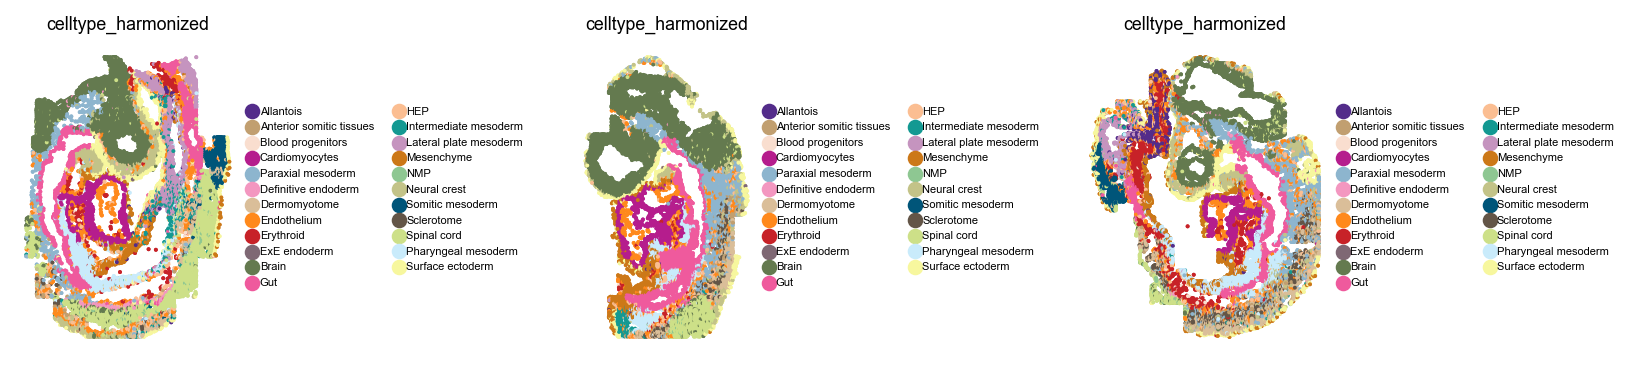

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    with plt.rc_context({"figure.figsize": (2, 2.5), "legend.fontsize": 5, "axes.titlesize": 8}):
        sq.pl.spatial_scatter(
            ad_sp,
            library_key="embryo",
            color="celltype_harmonized",
            shape=None,
            wspace=0.8,
        )

For the dissociated data, we can show a simple UMAP. 

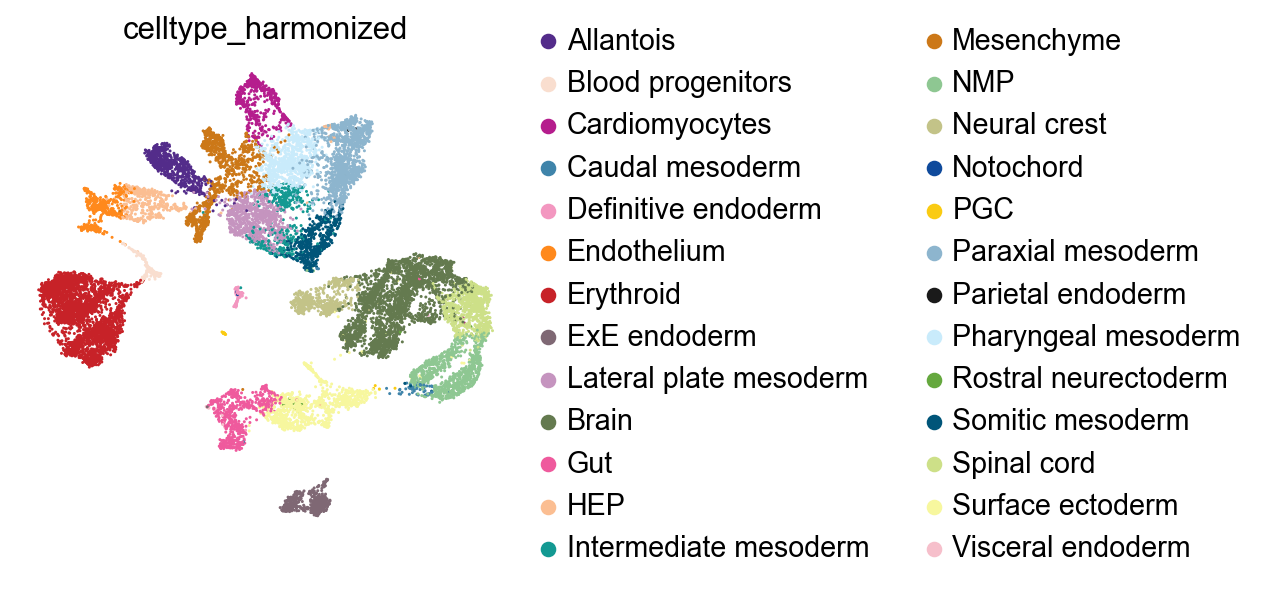

In [9]:
sc.pl.embedding(ad_diss, basis="X_umap", color="celltype_harmonized")

### Compute a joint embedding

Everything we do in `CellMapper` is based on a joint embedding between query (spatial) and reference (dissociated) data. For simplicity, we will compute such a joint embedding here with Harmony {cite:p}`korsunsky2019fast`. 

Note that we're using `mask_var="is_train"` to compute the PCA, which holds out test genes for the PCA, and for Harmony, which is based on the PCA. Thus, test genes will be masked for all downstream computations, because they all depend on the joint latent space. 

In [10]:
# let's define batch labels in both objects
ad_sp.obs["batch"] = ad_sp.obs["embryo"].copy()
ad_diss.obs["batch"] = ad_diss.obs["sample_rna"].copy()

# Harmony expects a combined AnnData object and a joint PCA
ad_combined = ad.concat(
    [ad_sp, ad_diss], join="inner", axis=0, label="modality", keys=["spatial", "dissociated"], merge="unique"
)

# Fix colors in the combined object
colors_sp = dict(
    zip(ad_sp.obs["celltype_harmonized"].cat.categories, ad_sp.uns["celltype_harmonized_colors"], strict=False)
)
colors_diss = dict(
    zip(ad_diss.obs["celltype_harmonized"].cat.categories, ad_diss.uns["celltype_harmonized_colors"], strict=False)
)
global_colors = colors_sp | colors_diss
ad_combined.uns["celltype_harmonized_colors"] = [
    global_colors[cat] for cat in ad_combined.obs["celltype_harmonized"].cat.categories
]

# compute a PCA on overlapping genes
ad_combined.X = ad_combined.layers["counts"].copy()
sc.pp.normalize_total(ad_combined, target_sum=1e4)
sc.pp.log1p(ad_combined)
sc.pp.pca(ad_combined, mask_var="is_train")

# run Harmony, place the joint embedding in the obsm slot
ad_combined.obsm["X_harmony"] = harmonize(ad_combined.obsm["X_pca"], ad_combined.obs, batch_key="modality")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
Reach convergence after 7 iteration(s).


For visualization, compute UMAPs in the joint PCA and integrated harmony latent spaces. 

In [11]:
# joint PCA space
sc.pp.neighbors(ad_combined, use_rep="X_pca")
sc.tl.umap(ad_combined, key_added="X_umap_pca")

# integrated harmony space
sc.pp.neighbors(ad_combined, use_rep="X_harmony")
sc.tl.umap(ad_combined, key_added="X_umap_harmony")

/Users/mlange/miniforge3/envs/cellmapper/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Visualize both with UMAP

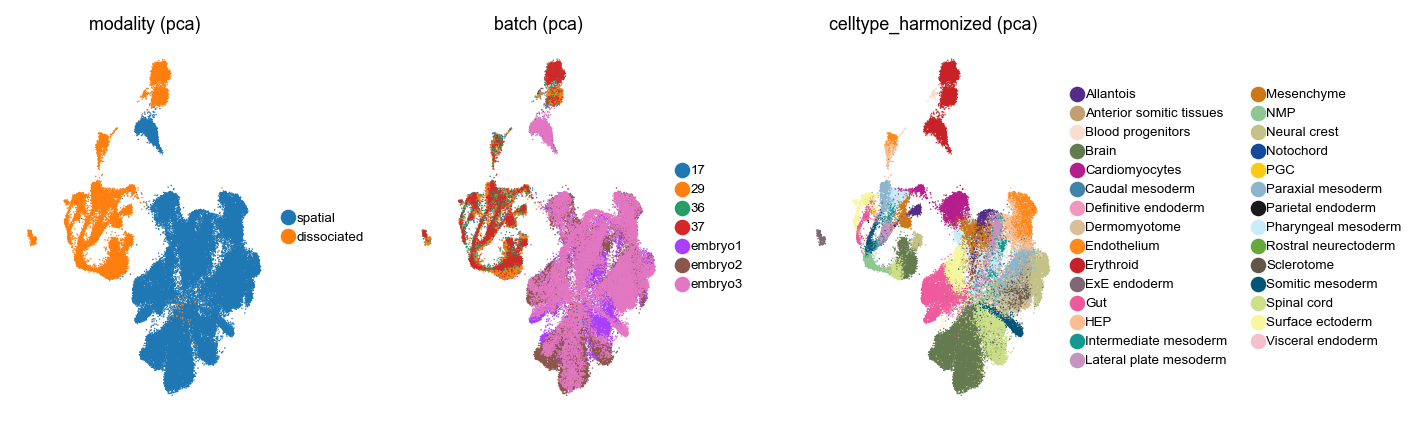

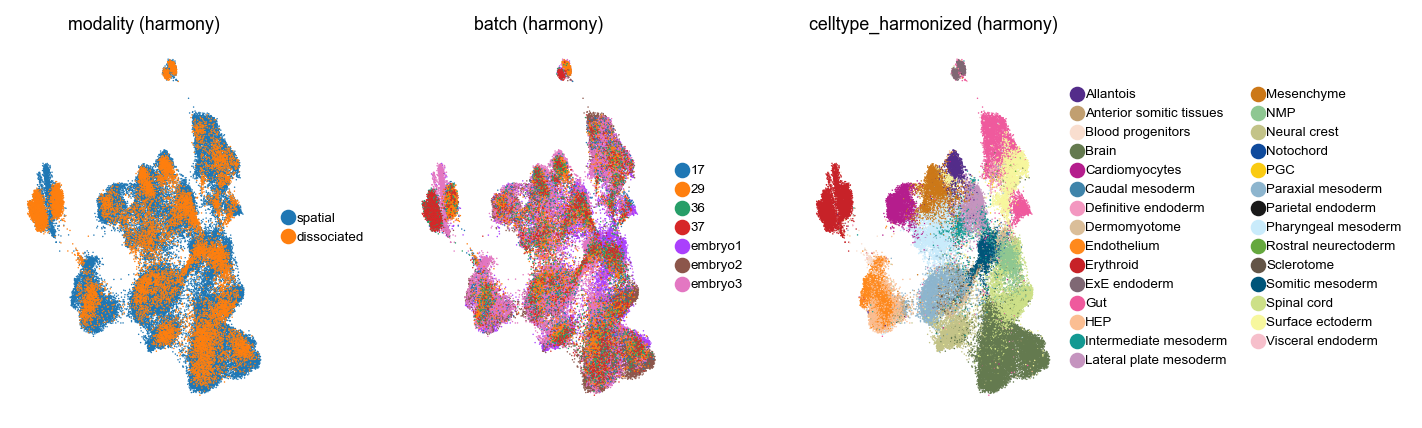

In [12]:
color = ["modality", "batch", "celltype_harmonized"]

with plt.rc_context({"figure.figsize": (2, 3), "legend.fontsize": 6, "axes.titlesize": 8}):
    for emb in ["pca", "harmony"]:
        sc.pl.embedding(
            ad_combined,
            basis=f"X_umap_{emb}",
            color=color,
            wspace=0.4,
            title=[f"{col} ({emb})" for col in color],
        )

Looks like Harmony aligned both datasets - to make this statement robust and quantitative, we should compute some metrics, like scIB metrics {cite:p}`luecken2022benchmarking`, but for the purpose of this tutorial, let's just work with this Harmony latent space. We will copy it back into the individual AnnData objects. 

In [13]:
ad_diss.obsm["X_harmony"] = ad_combined[ad_combined.obs["modality"] == "dissociated"].obsm["X_harmony"].copy()
ad_sp.obsm["X_harmony"] = ad_combined[ad_combined.obs["modality"] == "spatial"].obsm["X_harmony"].copy()

## Work with ObsMapper

### Initialize and compute the mapping matrix

`ObsMapper` is the CellMapper interface to map along the observation axis. 

In [14]:
omap = ObsMapper(query=ad_sp, reference=ad_diss)
omap

INFO     Initialized ObsMapper with 51787 query cells and 16496 reference cells.                                   


The central object in CellMapper is the `mapping_matrix`, which we will use throughout all use cases below. 

In [15]:
omap.compute_neighbors(use_rep="X_harmony", only_yx=True)
omap.compute_mapping_matrix()

INFO     Using sklearn to compute 30 neighbors.                                                                    
INFO     Computing mapping matrix using method 'gaussian'.                                                         
INFO     Row-normalizing the mapping matrix.                                                                       


### Transfer cell type labels

Let's pretend we don't have cell type annotations in the spatial data and we want to transfer them from the dissociated data. 

In [16]:
omap.map_obs(key="celltype_harmonized")

INFO     Categorical data mapped and stored with key 'celltype_harmonized_pred'.                                   


Let's take a look at original and predicted cell type labels for the spatial query data. We'll take `embryo1` as an example. 

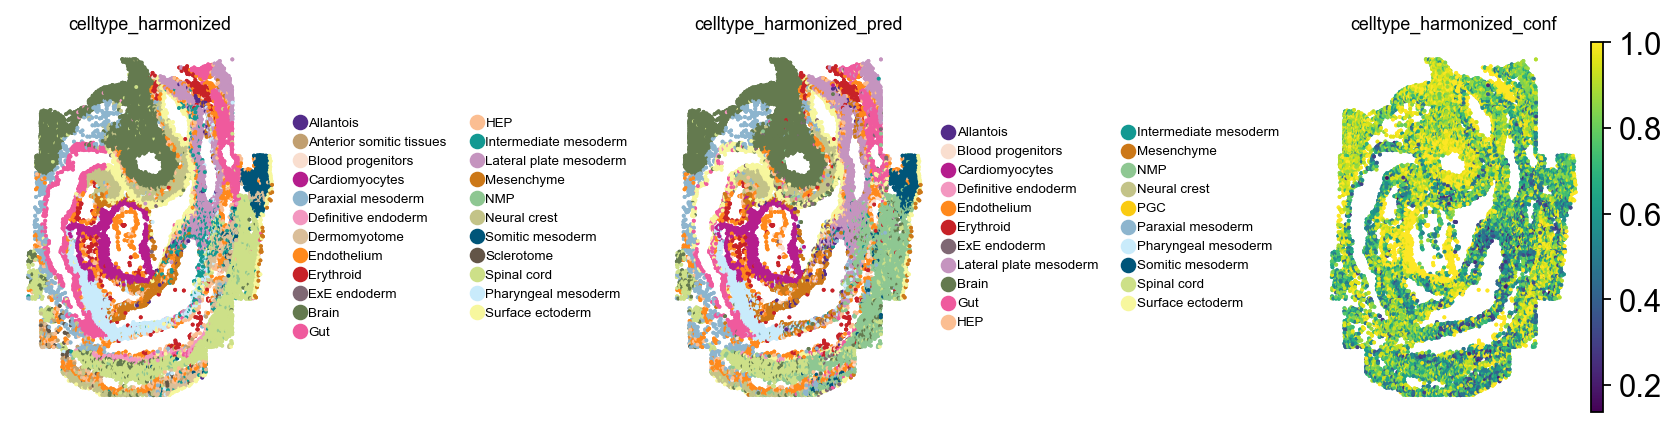

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    with plt.rc_context({"figure.figsize": (2, 3), "legend.fontsize": 6, "axes.titlesize": 8}):
        sq.pl.spatial_scatter(
            ad_sp,
            color=["celltype_harmonized", "celltype_harmonized_pred", "celltype_harmonized_conf"],
            library_key="embryo",
            library_id="embryo1",
            shape=None,
            wspace=1.1,
        )

For most cell types, this looks okay. Confidence scores are written to `.obs` let's take a look at their distribution: 

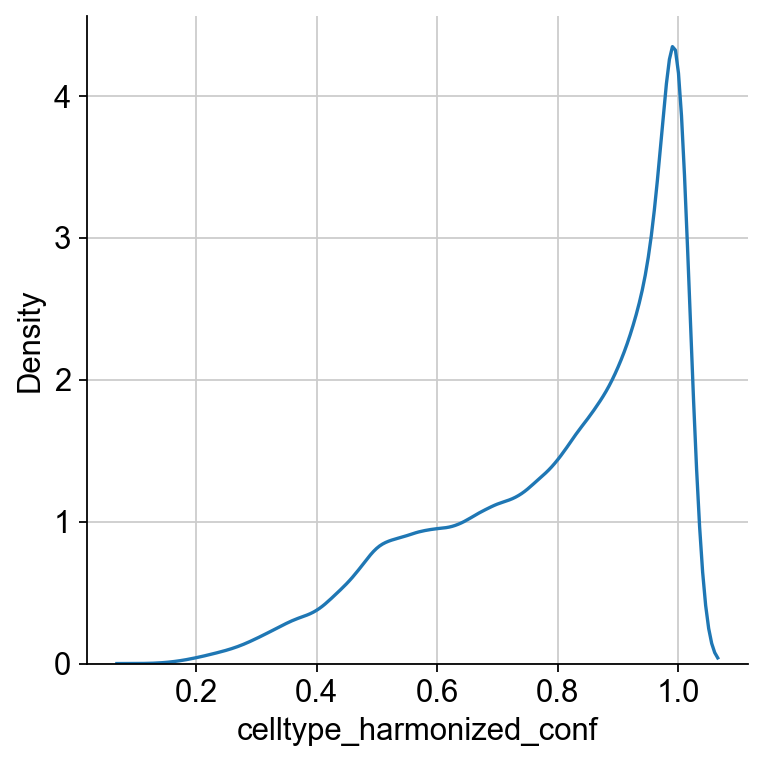

In [18]:
sns.displot(ad_sp.obs["celltype_harmonized_conf"], kind="kde")

To focus on high-confidence predictions, we could now threshold based on this score. To gain more insights into the mapping on the cell type level, let's look at a confusion matrix. 

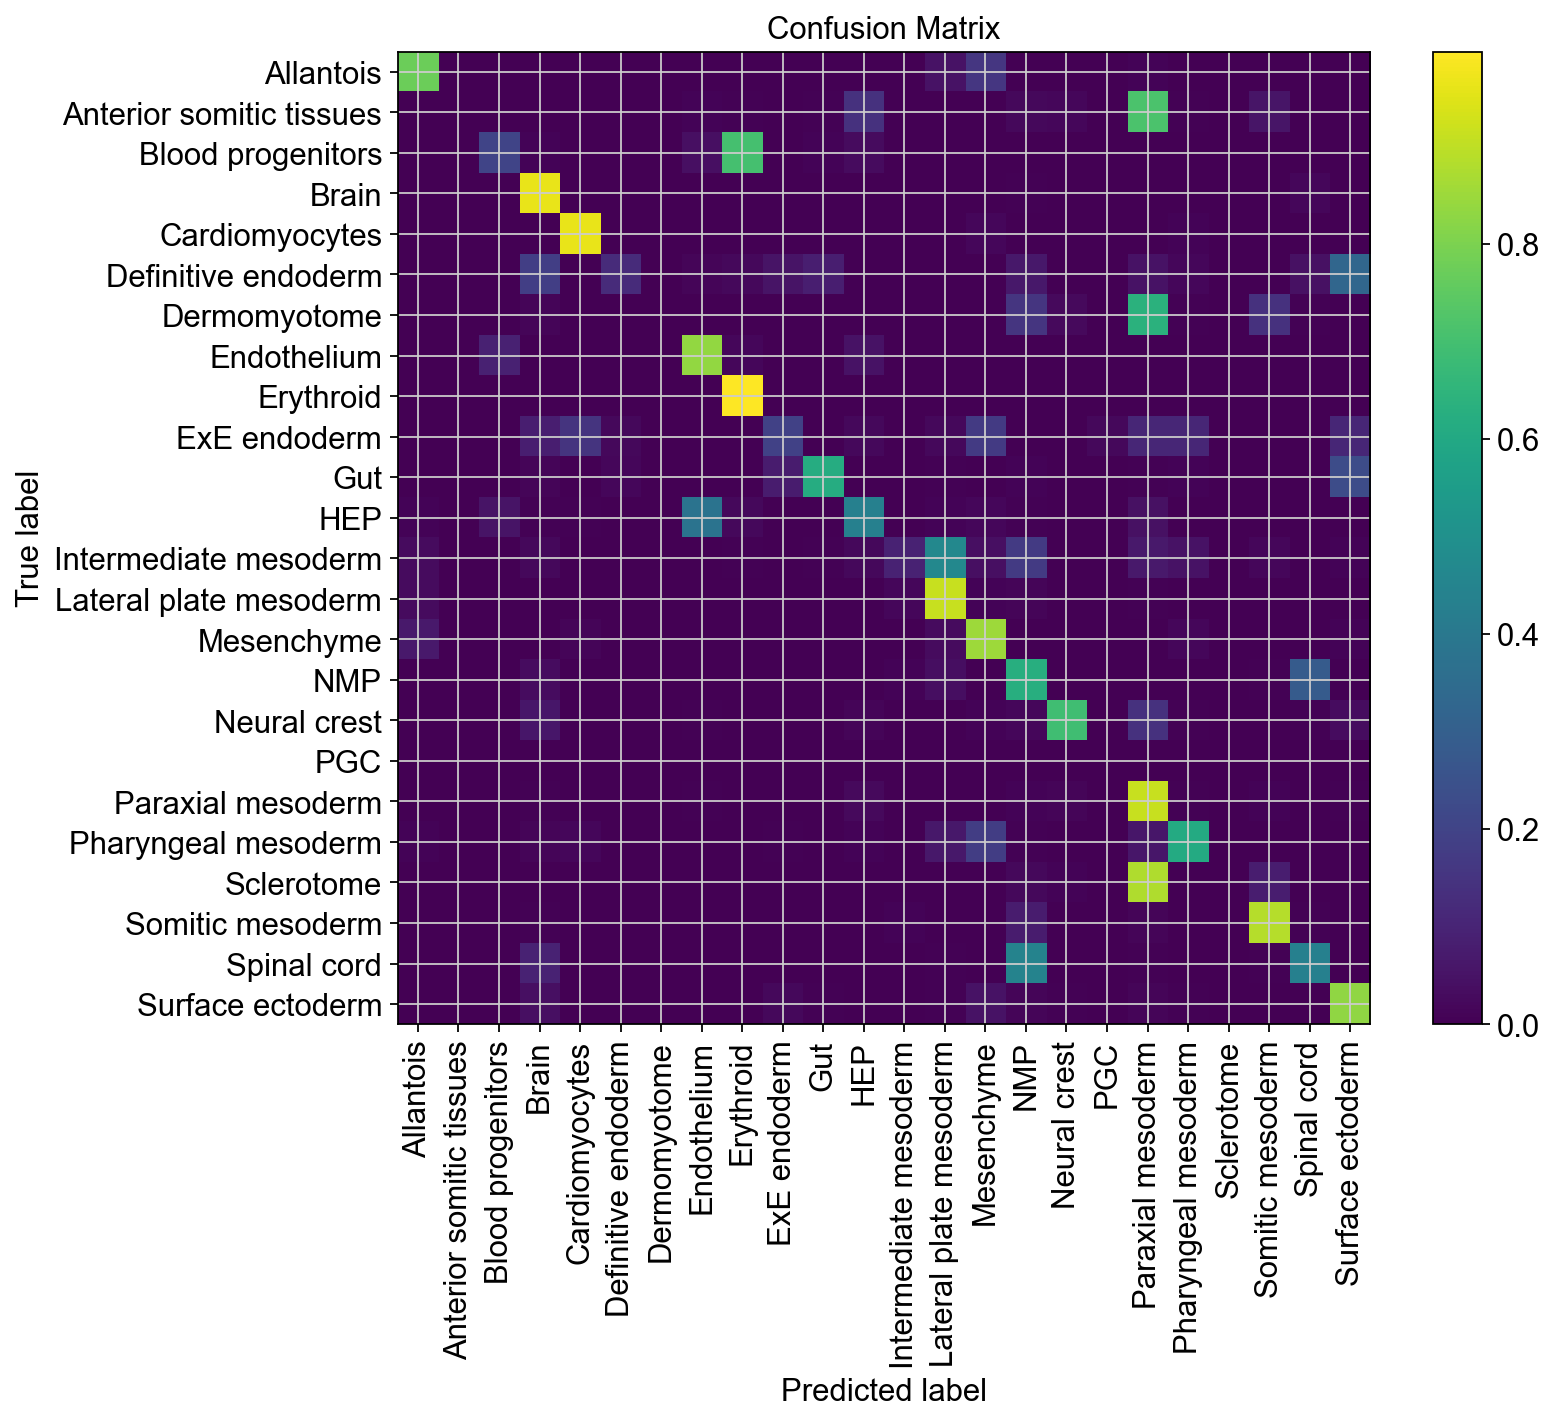

In [19]:
omap.plot_confusion_matrix(label_key="celltype_harmonized", include_values=False, normalize="true")

Except for a couple of outliers, some of which map to related tissues, this looks quite good. Let's quantify this next. For this evaluation, we can threshold based on the confidence score from above. 

In [20]:
omap.evaluate_label_transfer("celltype_harmonized", confidence_cutoff=0.4)

INFO     Accuracy: 0.7297, Precision: 0.7520, Recall: 0.7297, Weighted F1-Score: 0.7173, Macro F1-Score: 0.5205,   
         Excluded Fraction: 0.0376                                                                                 


A weighted f1 score of approx. 0.7 on this dataset is pretty good, given that the abundance of certain cell types varies strongly between spatial and dissociated data: 

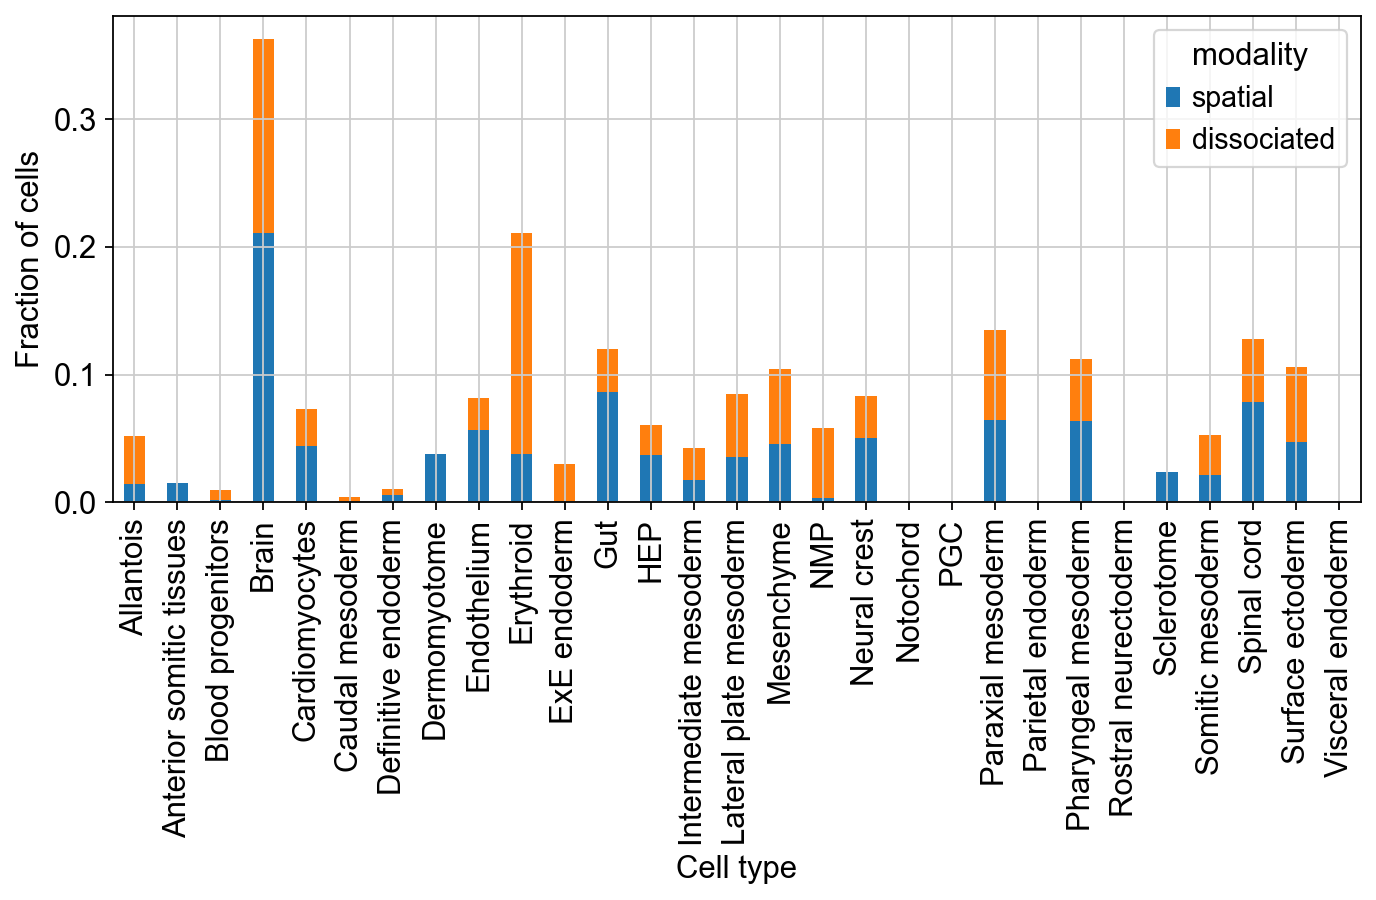

In [21]:
df = ad_combined.obs.groupby(["celltype_harmonized", "modality"], observed=False).size().unstack()
df /= df.sum(0)
ax = df.plot(kind="bar", stacked=True, figsize=(10, 4))

ax.set_ylabel("Fraction of cells")
ax.set_xlabel("Cell type")

plt.show()

### Transfer expression values

We have many more genes measured in the dissociated dataset, so let's impute their expression in space. Let's start by imputing normalized expression values in `.X`. 

In [22]:
omap.map_layers(key="X")
omap.evaluate_expression_transfer(layer_key="X", groupby="embryo", method="pearson", test_var_key="is_test")

INFO     Mapping expression data for key 'X'.                                                                      
INFO     Imputed expression matrix with shape (51787, 18499) converted to AnnData object.                          
         Observation metadata from query and feature metadata from reference were linked (not copied).             
INFO     Expression for layer 'X' mapped. Feature space matches reference (n_vars=18499).                          
INFO     Expression transfer evaluation (pearson): average value = 0.2103 (n_shared_genes=350, n_test_genes=50)    
INFO     Metrics per group defined in `query.obs['embryo']` computed and stored in `query.varm['metric_pearson']`  


This works okay, a mean correlation of 0.22 on held out test genes is okay, but not overwhelming. We can do better by imputing raw counts and adjusting the library size of imputed data. As a proxy for target library size, we'll use the empirical library size observed in space on trainining genes. 

In [62]:
omap.map_layers(key="counts")

# get the current and desired library sizes
current_libsizes = omap.query_imputed.X.sum(axis=1)
target_libsizes = ad_sp[:, ad_sp.var.query("is_train").index].layers["counts"].sum(axis=1).A1

# compute and apply scaling factors
scaling_factors = target_libsizes / current_libsizes
scaled_X = omap.query_imputed.X * scaling_factors[:, None]
assert np.isclose(target_libsizes, scaled_X.sum(axis=1)).all(), "Scaling factors did not work as expected."

# put it back into the imputed query object
omap.query_imputed.X = scaled_X.copy()

INFO     Mapping expression data for key 'counts'.                                                                 
INFO     Imputed expression matrix with shape (51787, 18499) converted to AnnData object.                          
         Observation metadata from query and feature metadata from reference were linked (not copied).             
INFO     Expression for layer 'counts' mapped. Feature space matches reference (n_vars=18499).                     


Let's check again for correlation, this time of course with raw counts. Let's stratify by `embryo`, to see whether there are differences in performance. 

In [63]:
omap.evaluate_expression_transfer(layer_key="counts", groupby="embryo", method="pearson", test_var_key="is_test")

INFO     Expression transfer evaluation (pearson): average value = 0.3479 (n_shared_genes=350, n_test_genes=50)    
INFO     Metrics per group defined in `query.obs['embryo']` computed and stored in `query.varm['metric_pearson']`  


That's quite a bit better, and already quite competitive. To make this comparison robust, we would have to use k-fold cross validation though, to make sure the random gene set does not influence our results.  We can look into the mean correlation per embryo on test genes now. 

In [64]:
ad_sp[:, ad_sp.var["is_test"]].varm["metric_pearson"].mean()

embryo1    0.317171
embryo2    0.335006
embryo3    0.360048
dtype: float32

It looks like this worked best on `embryo3`, so let's visualize imputed (written to `.query_imputed`) and original gene expressio of some (held out) test genes for this embryo. We'll use scanpy here as it allows us to specify a percentile for plotting via `vmax`. 

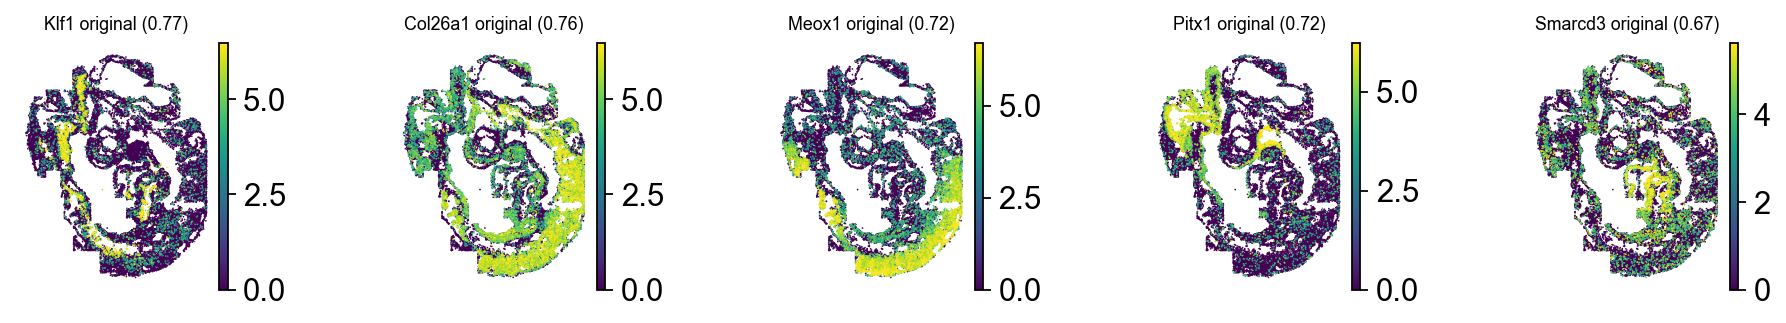

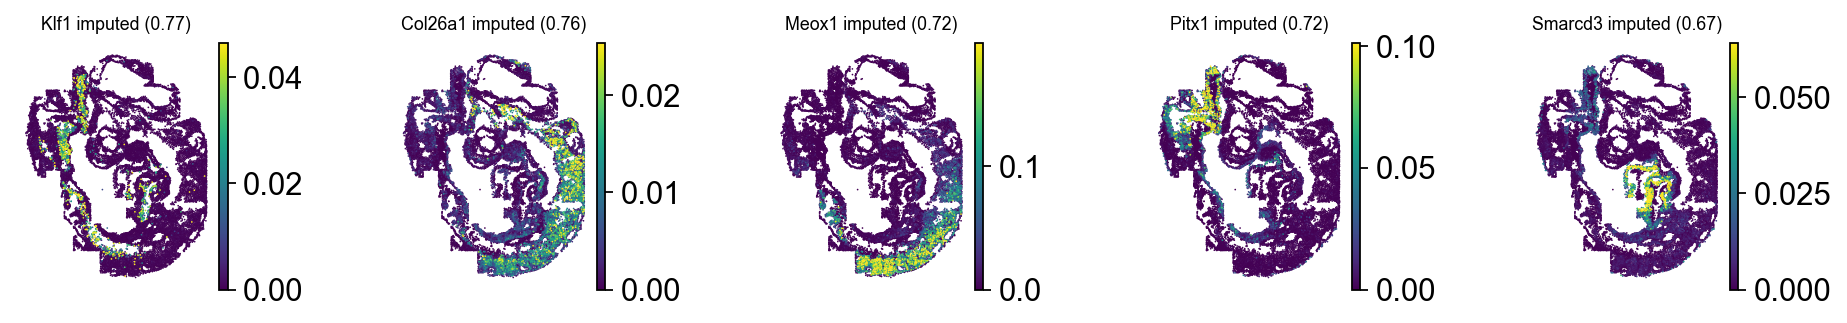

In [65]:
obs_mask = ad_sp.obs["embryo"] == "embryo3"
gene_series = (
    ad_sp[:, ad_sp.var["is_test"]].varm["metric_pearson"].sort_values("embryo3", ascending=False).head(5)["embryo3"]
)
gene_names = gene_series.index.tolist()
gene_corrs = gene_series.values

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with plt.rc_context({"figure.figsize": (2, 2), "legend.fontsize": 6, "axes.titlesize": 8}):
        for adata, key in zip([ad_sp[obs_mask], omap.query_imputed[obs_mask]], ["original", "imputed"], strict=False):
            sc.pl.spatial(
                adata,
                spot_size=2,
                color=gene_names,
                title=[f"{name} {key} ({corr:.2f})" for name, corr in zip(gene_names, gene_corrs, strict=False)],
                ncols=len(gene_names),
                size=2,
                vmax="p99",
            )

ObsMapper supports further metrics to compare transferred expression, such as spearman correlation or Jensen–Shannon divergence. 